# Projet DM Part 1 : Exploitation des données et Extraction des règles d’associations

In [2]:
import numpy as np
import pandas as pd
import copy as cp
import statistics
import re
import math
import matplotlib.pyplot as plt 
from itertools import combinations
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
from mlxtend.preprocessing import TransactionEncoder
import pandas as pd
import matplotlib.pyplot as plt
from  collections import Counter
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
from mlxtend.preprocessing import TransactionEncoder
import time
import csv
from sklearn.linear_model import LinearRegression
from datetime import datetime
import random
import plotly.express as px
import seaborn as sns
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("Set2")

## Partie 1/3 
## 1.1 Données statiques

### 1.1.1 Mnipulation dataset

Importer et visualiser le contenu du dataset:

In [91]:
dataset1 = np.genfromtxt('datasets\Dataset1.csv', delimiter=',', dtype=float, skip_header=1)
datas = pd.read_csv('datasets\Dataset1.csv')
header = np.genfromtxt('datasets\Dataset1.csv', delimiter=',', dtype=str, max_rows=1)
name_attribut={i:f"{n}" for i,n in enumerate(header)}

print(name_attribut)
pd.DataFrame(dataset1, columns=header)

{0: 'N', 1: 'P', 2: 'K', 3: 'pH', 4: 'EC', 5: 'OC', 6: 'S', 7: 'Zn', 8: 'Fe', 9: 'Cu', 10: 'Mn', 11: 'B', 12: 'OM', 13: 'Fertility'}


,N,P,K,pH,EC,OC,S,Zn,Fe,Cu,Mn,B,OM,Fertility
0,138.0,8.6,560.0,7.46,0.62,0.70,5.90,0.24,0.31,0.77,8.71,0.11,1.2040,0.0
1,213.0,7.5,338.0,7.62,0.75,1.06,25.40,0.30,0.86,1.54,2.89,2.29,1.8232,0.0
2,163.0,9.6,718.0,7.59,0.51,1.11,14.30,0.30,0.86,1.57,2.70,2.03,1.9092,0.0
3,157.0,6.8,475.0,7.64,0.58,0.94,26.00,0.34,0.54,1.53,2.65,1.82,1.6168,0.0
4,270.0,9.9,444.0,7.63,0.40,0.86,11.80,0.25,0.76,1.69,2.43,2.26,1.4792,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
880,276.0,9.2,370.0,7.62,0.62,0.49,6.64,0.42,3.57,0.63,6.48,0.32,0.8428,1.0
881,320.0,13.8,391.0,7.38,0.65,1.07,5.43,0.58,4.58,1.02,13.25,0.53,1.8404,2.0
882,264.0,10.3,475.0,7.49,0.74,0.88,10.56,0.45,7.36,1.87,10.63,0.63,1.5136,0.0
883,220.0,8.6,444.0,7.43,0.65,0.72,11.70,0.37,0.66,0.90,2.19,1.82,1.2384,0.0


Description globale du dataset:

In [92]:
def infos_dataset():
    print(f"le dataset contient {dataset1.shape[0]-1} instances")
    print(f"le dataset contient {dataset1.shape[1]} attributs")
    
infos_dataset()

le dataset contient 884 instances
le dataset contient 14 attributs


Description de chaque attribut: 

In [93]:
pd.DataFrame(dataset1, columns=header).describe()

,N,P,K,pH,EC,OC,S,Zn,Fe,Cu,Mn,B,OM,Fertility
count,885.000000,883.000000,885.000000,885.000000,885.000000,884.000000,885.000000,885.000000,885.000000,884.000000,885.000000,885.000000,885.000000,885.000000
mean,246.997740,14.555266,501.338983,7.511955,0.543921,0.617817,7.545808,0.468723,4.126757,0.952002,8.653616,0.593424,1.063718,0.592090
std,77.359316,21.930990,129.104610,0.464577,0.141324,0.841123,4.418087,1.888892,3.108088,0.465527,4.300963,0.574736,1.446265,0.578405
min,6.000000,2.900000,11.000000,0.900000,0.100000,0.100000,0.640000,0.070000,0.210000,0.090000,0.110000,0.060000,0.172000,0.000000
25%,201.000000,6.800000,412.000000,7.350000,0.430000,0.380000,4.700000,0.280000,2.050000,0.630000,6.210000,0.270000,0.653600,0.000000
50%,257.000000,8.100000,475.000000,7.500000,0.550000,0.590000,6.640000,0.360000,3.560000,0.930000,8.340000,0.410000,1.014800,1.000000
75%,307.000000,10.700000,581.000000,7.630000,0.640000,0.780000,8.750000,0.470000,6.320000,1.250000,11.470000,0.610000,1.341600,1.000000
max,383.000000,125.000000,1560.000000,11.150000,0.950000,24.000000,31.000000,42.000000,44.000000,3.020000,31.000000,2.820000,41.280000,2.000000


### 1.1.2 Analyse caracteristiques des attributs

Calculer les mesures de tendance centrale et en déduire les symétries:

In [94]:
##################Fonction Predef###################

def ecart_type(attribut):
    datasetCurrated=np.delete( dataset1[:,attribut], val_manquante(attribut))
    return np.std(datasetCurrated)
def quartiles(attribut):
    datasetCurrated=np.delete( dataset1[:,attribut], val_manquante(attribut))
    q0=np.percentile(datasetCurrated, 0)
    q1=np.percentile(datasetCurrated, 25)
    q2=np.percentile(datasetCurrated, 50)
    q3=np.percentile(datasetCurrated, 75)
    q4=np.percentile(datasetCurrated, 100)
    return q0,q1,q2,q3,q4
def tendance_centrales(attribut):
    datasetCurrated=np.delete( dataset1[:,attribut], val_manquante(attribut))
    moyenne=datasetCurrated.mean()
    mediane=np.median(datasetCurrated)
    mode = statistics.mode(datasetCurrated)

    return moyenne,mediane,mode

##########Fonctions home made#######################

def calcul_mediane(attribut):
    datasetCurrated=np.delete( dataset1[:,attribut], val_manquante(attribut))
    liste = cp.deepcopy(datasetCurrated)
    liste.sort()
    if liste.size % 2 !=0 :
      
        mediane=liste[((liste.size+1)//2) -1]
    else :
        mediane=(liste[(liste.size//2)-1]+liste[liste.size//2])/2
    return mediane
def val_manquante(attribut):
    L=[]
    for i in range(0,len(dataset1[:,attribut])):
        if not re.fullmatch(r"\d+\.(:?\d+)?", str(dataset1[i, attribut])):
            L.append(i)
    return L
def tendance_centrales_homeMade(attribut):
    datasetCurrated=np.delete( dataset1[:,attribut], val_manquante(attribut))
    moyenne2= datasetCurrated.sum() / datasetCurrated.shape[0]
    mediane2=calcul_mediane(attribut)
    unique_values, counts = np.unique(datasetCurrated, return_counts=True)
    Indicemax=np.where(counts == max(counts))[0]
    mode2=[unique_values[i] for i in Indicemax]

    return [moyenne2,mediane2,mode2]
def quartilles_homeMade(attribut):
    datasetCurrated=np.delete( dataset1[:,attribut], val_manquante(attribut))
    liste = cp.deepcopy(datasetCurrated)
    liste.sort()
    q0=liste[0]
    q1=(liste[liste.size//4-1]+liste[liste.size//4]) /2
    q3=(liste[liste.size*3//4-1]+liste[liste.size*3//4]) /2
    q2=calcul_mediane(attribut)
    q4=liste[-1]
    return [q0,q1,q2,q3,q4]
def ecart_type_home_made(attribut):
     datasetCurrated=np.delete( dataset1[:,attribut], val_manquante(attribut))
     mean = np.mean(datasetCurrated)
     ecarts = [(val - mean) ** 2 for val in datasetCurrated]
     variance = np.mean(ecarts) 
     return np.sqrt(variance)


for i in range(0,dataset1.shape[1]):
    print(tendance_centrales(i))
    print(tendance_centrales_homeMade(i))
    print(quartilles_homeMade(i))
    print(quartiles(i))
    print(ecart_type(i))
    print(ecart_type_home_made(i))

(246.99774011299436, 257.0, 207.0)
[246.99774011299436, 257.0, [207.0]]
[6.0, 201.0, 257.0, 307.0, 383.0]
(6.0, 201.0, 257.0, 307.0, 383.0)
77.3155979722602
77.3155979722602
(14.555266138165347, 8.1, 8.3)
[14.555266138165347, 8.1, [8.3]]
[2.9, 6.8, 8.1, 10.7, 125.0]
(2.9, 6.8, 8.1, 10.7, 125.0)
21.918567580264458
21.918567580264458
(501.33898305084745, 475.0, 444.0)
[501.33898305084745, 475.0, [444.0]]
[11.0, 412.0, 475.0, 581.0, 1560.0]
(11.0, 412.0, 475.0, 581.0, 1560.0)
129.03164901071148
129.03164901071148
(7.511954802259887, 7.5, 7.5)
[7.511954802259887, 7.5, [7.5]]
[0.9, 7.35, 7.5, 7.63, 11.15]
(0.9, 7.35, 7.5, 7.63, 11.15)
0.4643147167054418
0.4643147167054418
(0.5439209039548023, 0.55, 0.62)
[0.5439209039548023, 0.55, [0.53, 0.62]]
[0.1, 0.43, 0.55, 0.64, 0.95]
(0.1, 0.43, 0.55, 0.64, 0.95)
0.14124424677359604
0.14124424677359604
(0.6178167420814481, 0.59, 0.88)
[0.6178167420814481, 0.59, [0.88]]
[0.1, 0.38, 0.59, 0.78, 24.0]
(0.1, 0.38, 0.59, 0.78, 24.0)
0.8406466256531129
0.8

Construire une boîte à moustache et afficher les données aberrantes:

{11.0, 876.0, 845.0, 887.0, 1560.0, 127.0}


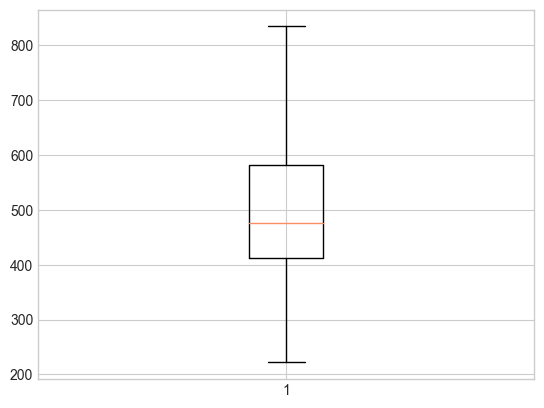

In [95]:
def Boite_a_moustache(attribut,boolen):
    abberante=[]
    liste=[]
    q3=quartilles_homeMade(attribut)[-2]
    q1=quartilles_homeMade(attribut)[1]
    IQR=(quartilles_homeMade(attribut)[-2]-quartilles_homeMade(attribut)[1])*1.5
    datasetCurrated=np.delete( dataset1[:,attribut], val_manquante(attribut))

    for var in datasetCurrated:
        if (var <(q3+IQR) and var>(q1-IQR)):
            liste.append(var)
        else:
            abberante.append(var)  
    print(set(abberante))
    if boolen:
        plt.boxplot(datasetCurrated)
    
    else:
        plt.boxplot(liste)
    
Boite_a_moustache(2,False)


Construire un histogramme et visualiser la distribution des données:

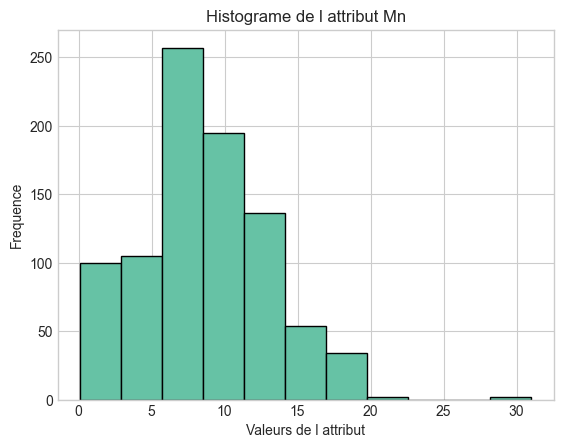

In [96]:
def Histogramme(attribut):
    datasetCurrated=np.delete( dataset1[:,attribut], val_manquante(attribut))
    plt.hist(datasetCurrated,bins=math.ceil(1+(10/3)*np.log10(dataset1.shape[0])),edgecolor='black')
    plt.title(f'Histograme de l attribut {name_attribut[attribut]}')
    plt.xlabel('Valeurs de l attribut')
    plt.ylabel('Frequence')

Histogramme(10)

Construire et afficher des diagrammes de dispersion des données et en déduire les
corrélations entre les propriétés du sol :

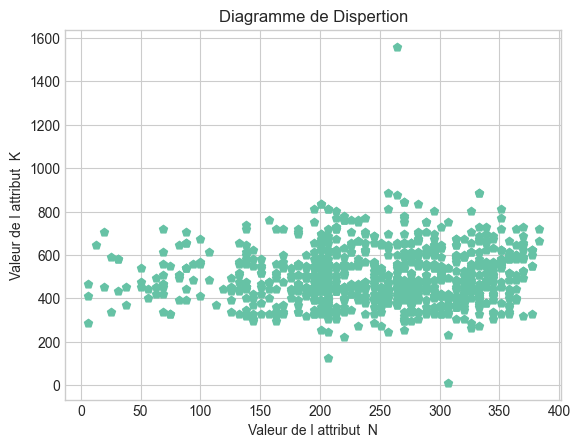

In [97]:
def scatterplot(attribut,attribut2):
    plt.scatter(dataset1[:,attribut],dataset1[:,attribut2],marker ='p')
    plt.title('Diagramme de Dispertion')
    plt.xlabel(f'Valeur de l attribut  {name_attribut[attribut]}')
    plt.ylabel(f'Valeur de l attribut  {name_attribut[attribut2]}')
    plt.show()

scatterplot(0,2)

[16, 34, 8, 874]


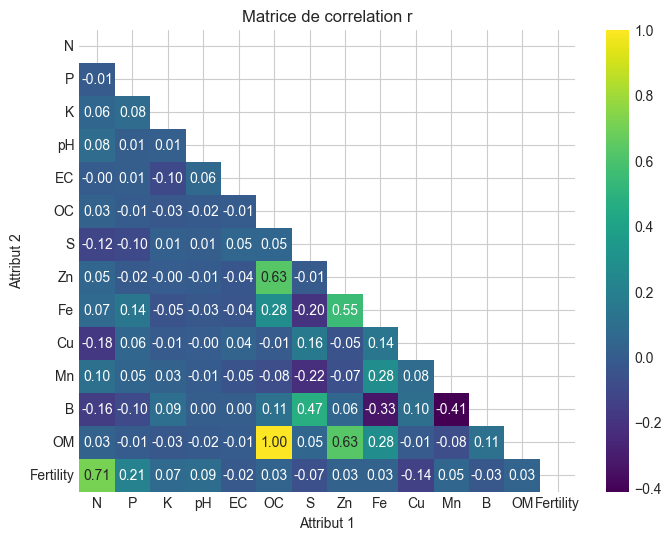

In [98]:
missing=[]
for i in range(0,dataset1.shape[1]):
    missing+=val_manquante(i)

print(missing)

dataCurated=np.delete( dataset1, list(set(missing)),axis=0)
df = pd.DataFrame(dataCurated)

correlation_matrix = df.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='viridis', fmt=".2f",mask=np.triu(np.ones_like(correlation_matrix, dtype=bool),k=0),xticklabels=name_attribut.values(), yticklabels=name_attribut.values())
plt.title("Matrice de correlation r")
plt.xlabel("Attribut 1")
plt.ylabel("Attribut 2")

plt.show()

In [99]:
def coef_correl(attribut1,attribut2):
    missing=val_manquante(attribut1)+val_manquante(attribut2)
    dataCurated=np.delete( dataset1, list(set(missing)),axis=0)
    moy1=np.mean(dataCurated[:,attribut1])
    moy2=np.mean(dataCurated[:,attribut2])
    e1=ecart_type_home_made(attribut1)
    e2=ecart_type(attribut2)
    return round((dataCurated[:,attribut1].dot(dataCurated[:,attribut2])-(len(dataCurated)*moy1*moy2))/((len(dataCurated)-1)*(e1*e2)),3)

def matric_pearson():
    i=0
    matrix=np.zeros((dataset1.shape[1],dataset1.shape[1]))
    print(matrix.shape)
    for i in range(0,dataset1.shape[1]):
        for j in range(i,dataset1.shape[1]):
            matrix[i,j]=coef_correl(i,j)
    return matrix

mat=matric_pearson()
pd.DataFrame(mat)

(14, 14)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,1.001,-0.011,0.052,0.078,-0.005,0.030,-0.126,0.054,0.073,-0.185,0.103,-0.169,0.030,0.709
1,0.000,1.001,0.083,0.005,0.005,-0.009,-0.099,-0.017,0.141,0.055,0.045,-0.097,-0.009,0.211
2,0.000,0.000,1.001,0.010,-0.099,-0.030,0.018,-0.003,-0.056,-0.010,0.025,0.102,-0.031,0.066
3,0.000,0.000,0.000,1.001,0.058,-0.016,0.012,-0.008,-0.034,-0.001,-0.008,0.008,-0.015,0.089
4,0.000,0.000,0.000,0.000,1.001,-0.007,0.051,-0.036,-0.043,0.034,-0.046,-0.002,-0.008,-0.025
5,0.000,0.000,0.000,0.000,0.000,1.001,0.047,0.627,0.282,-0.009,-0.079,0.107,1.001,0.035
6,0.000,0.000,0.000,0.000,0.000,0.000,1.001,-0.014,-0.209,0.160,-0.226,0.478,0.047,-0.064
7,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.001,0.548,-0.051,-0.065,0.055,0.626,0.032
8,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.001,0.139,0.278,-0.336,0.282,0.034
9,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.001,0.082,0.102,-0.009,-0.138


### 1.1.3 Prétraitement

Traitement des valeurs manquantes et aberrantes :

In [100]:
def DiscretisationA(attribut):
    global dataset1
    vals=dataset1[:,attribut].copy()
    vals.sort()
    q = 1+(10/3)*np.log10(dataset1.shape[0])
    nbrelmt=math.ceil(dataset1[:,attribut].shape[0]/q)
    
    for  val in range(0,dataset1[:,attribut].shape[0]):  
        for i in range(0,vals.shape[0],nbrelmt):
            if(vals[i]>dataset1[val,attribut]):
                sup=i
                break
        dataset1[val,attribut]=np.median(vals[sup-nbrelmt:sup])  

In [101]:
def remplacement_val_manquantes(methode,attribut):
    global dataset1
    missing=val_manquante(attribut)
    for i in missing:
        if methode==0:
            dataset1[i,attribut]= statistics.mode(dataset1[:,attribut])    
        else:
            dataset1[i,attribut]= np.mean([dataset1[j,attribut] for j in range(0,len(dataset1)) if dataset1[j,-1]==dataset1[i,-1] and not j in missing])

def remplacement_val_aberrantes(methode,attribut):
    global dataset1
    abberante=[]
    if methode==0:
        IQR=(quartilles_homeMade(attribut)[-2]-quartilles_homeMade(attribut)[1])*1.5
        for i in range(0,len(dataset1[:,attribut])):
            if (dataset1[i,attribut] >(quartilles_homeMade(attribut)[-2]+IQR) or dataset1[i,attribut]<(quartilles_homeMade(attribut)[1]-IQR)):
                abberante.append(i)
        X = np.delete(dataset1, attribut, axis=1)
        X = np.delete(X, abberante, axis=0)
        y=dataset1[:,attribut]
        y= np.delete(y, abberante, axis=0).reshape(-1, 1)

        model = LinearRegression().fit(X, y)
         
        for i in abberante:
            x2=np.delete(dataset1, attribut, axis=1)
            X_new =x2[i,:].T.reshape(1, -1)
            dataset1[i,attribut]=model.predict(X_new)[0][0]
    else:
         DiscretisationA(attribut)

def remplacement_manquant_generale(methode):
    for i in range(0,dataset1.shape[1]):
        remplacement_val_manquantes(methode,i) 

def remplacement_aberantes_generale(methode):
    for i in range(0,dataset1.shape[1]-1):
        remplacement_val_aberrantes(methode,i)

# Tests
print(dataset1[16,1])
print(dataset1[598,1])
remplacement_manquant_generale(0)
remplacement_aberantes_generale(0)
print(dataset1[16,1])
print(dataset1[598,1])


nan
103.1


8.3
9.141016424398625


Réduction des données (élimination des redondances) horizontales / verticales :

In [102]:
def reduire_row():
     global dataset1
     l1=len(dataset1)
     print(len(dataset1))
     dataset1= np.unique(dataset1, axis=0, return_index=False)
     print(len(dataset1))

def coef_correl(attribut1,attribut2):
    moy1=np.mean(dataset1[:,attribut1])
    moy2=np.mean(dataset1[:,attribut2])
    e1=ecart_type_home_made(attribut1)
    e2=ecart_type(attribut2)
    return (dataset1[:,attribut1].dot(dataset1[:,attribut2])-(len(dataset1)*moy1*moy2))/((len(dataset1)-1)*(e1*e2))

def reduire_dim(treashold):
    global dataset1
    to_delete=[]
    for i in range(0,dataset1.shape[1]-1):
        for j in range(i+1,dataset1.shape[1]):
            if (np.abs(coef_correl(i,j))>treashold):
                print(i,j)
                to_delete.append(i)
    dataset1 = np.delete(dataset1,to_delete, axis=1)

reduire_row()

correlation_matrix = np.corrcoef(dataset1[:,0],dataset1[:,0])
pearson_coefficient = correlation_matrix[0, 1]
print("Pearson Correlation Coefficient:", pearson_coefficient)
print(coef_correl(0,0))
print(dataset1.shape[1])
reduire_dim(0.75)#0 1
print(dataset1.shape[1])



885
882
Pearson Correlation Coefficient: 1.0
1.001135073779799
14


5 12
13


Normalisation des données :

In [103]:
def normalisation(methode,attribut):
    global dataset1
    if methode:
        vmin = 0
        vmax= 1
        vminOld=dataset1[:,attribut].min()
        vmaxOld=dataset1[:,attribut].max()
        for  val in range(0,dataset1[:,attribut].shape[0]):
            dataset1[val,attribut]=vmin+(vmax-vmin)*((dataset1[val,attribut]-vminOld)/(vmaxOld-vminOld))
    else:
        vmean=np.mean(dataset1[:,attribut])
        s=np.mean( (dataset1[:,attribut]  -vmean)**2)
        for  val in range(0,dataset1[:,attribut].shape[0]):
            dataset1[val,attribut]=(dataset1[val,attribut]-vmean)/s 
   
def normalisation_generale(methode):
    for i in range(0,dataset1.shape[1]):
        normalisation(methode,i)
normalisation_generale(1)
pd.DataFrame(dataset1)

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,0.000000,0.396947,0.379085,0.587156,0.720000,0.679379,0.191921,0.415861,0.601990,0.320794,0.212062,0.044831,0.0
1,0.000000,0.412214,0.413399,0.366972,0.186667,0.774011,0.265736,0.036750,0.398010,0.109195,0.325528,0.030586,0.5
2,0.000000,0.435115,0.517974,0.091743,0.253333,0.189266,0.155013,0.207930,0.616915,0.420063,0.368803,0.024301,0.0
3,0.018018,0.282443,0.292484,0.458716,0.493333,0.590395,0.295263,0.041586,0.542289,0.185475,0.317691,0.033099,0.0
4,0.018018,0.366412,0.362745,0.330275,0.626667,0.745763,0.118105,0.071567,0.393035,0.132706,0.277580,0.030586,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
877,0.981982,0.396947,0.534314,0.495413,0.560000,0.851695,0.155013,0.072534,0.084577,0.167189,0.341143,0.009218,0.5
878,0.981982,0.435115,0.534314,0.535327,0.466667,0.223164,0.221447,0.087041,0.059701,0.052769,0.359366,0.019692,0.5
879,0.981982,0.633588,0.655229,0.770642,0.586667,0.223164,0.221447,0.064797,0.109453,0.053292,0.728387,0.018435,1.0
880,1.000000,0.627656,0.723856,0.526830,0.533333,0.569209,0.243592,0.044487,0.124378,0.157785,0.426366,0.023044,1.0


## Part 2/3
## 1.2 Données temporelles

Importer et visualiser le contenu du dataset 2:

In [26]:
datas2 = pd.read_csv('Dataset2.csv')
datas2 = datas2.replace({pd.NA: np.nan})
dataset = datas2.to_numpy()

numeric_columns = datas2.select_dtypes(include=['int', 'float']).columns.tolist() # column label
numeric_columns = [datas2.columns.get_loc(col) for col in numeric_columns] #column index
print(numeric_columns)
# types des attributs
print("Types des différents attributs : ", [type(att) for att in dataset[0, :]])

# 10 premières instances du dataset 2
print(dataset[:10])

[0, 1, 2, 5, 6, 7, 8, 9, 10]
Types des différents attributs :  [<class 'int'>, <class 'int'>, <class 'int'>, <class 'str'>, <class 'str'>, <class 'float'>, <class 'float'>, <class 'float'>, <class 'float'>, <class 'float'>, <class 'float'>]
[[95129 32 39741 '10/11/2020' '10/31/2020' 22.0 2543.0 23.0 2.6 304.7 0.9]
 [95129 43 39741 '5/30/2021' '6/19/2021' nan 3315.0 14.0 1.1 397.2 0.4]
 [95129 40 39741 '3/28/2021' '4/17/2021' 34.0 4816.0 37.0 4.1 577.1 0.8]
 [95129 55 39741 '2/6/2022' '2/26/2022' 110.0 10194.0 175.0 13.2 1221.5
  1.7]
 [95129 44 39741 '6/20/2021' '7/10/2021' 14.0 3033.0 17.0 1.7 363.4 0.6]
 [95129 54 39741 '1/16/2022' '2/5/2022' 624.0 13479.0 817.0 74.8 1615.1
  6.1]
 [95129 25 39741 '5/17/2020' '6/6/2020' nan 762.0 nan 0.4 91.3 0.4]
 [95129 30 39741 '8/30/2020' '9/19/2020' 20.0 1773.0 20.0 2.4 212.4 1.1]
 [95129 31 39741 '9/20/2020' '10/10/2020' 12.0 2120.0 12.0 1.4 254.0 0.6]
 [95129 66 39741 '9/25/2022' '10/15/2022' 66.0 1571.0 78.0 7.9 188.2 5.0]]


Définir un mapping d'années pour les dates qui n'ont pas d'année :

In [27]:
datas2['Start date'] = pd.to_datetime(datas2['Start date'], errors='coerce')
datas2['end date'] = pd.to_datetime(datas2['end date'], errors='coerce')

yearly_intervals = datas2.groupby((datas2['Start date'].dt.year))['time_period'].agg(['min', 'max'])

year_mapping = {}

for year, interval in yearly_intervals.iterrows():
    year_mapping[(interval['min'], interval['max'])] = int(year)

print(year_mapping)

{(18, 18): 2019, (19, 35): 2020, (36, 53): 2021, (54, 155): 2022}


Définir une fonction pour le traitement des dates :

In [28]:
def convert_date(time_period, date, year_mapping):
    date = str(date)
    dd_mm_yy = re.compile(r'\b\d{1,2}/\d{1,2}/\d{4}\b')
    dd_mmm = re.compile(r'\b\d{1,2}-[a-zA-Z]{3}\b')

    if dd_mm_yy.match(date):
        formatted_date = datetime.strptime(date, '%m/%d/%Y')
        return np.datetime64(formatted_date)
    elif dd_mmm.match(date):
        day, month = date.split('-')
        month_dict = {'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, 'May': 5, 'Jun': 6, 'Jul': 7, 'Aug': 8, 'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12}
        month = month_dict[month]
        for interval, y in year_mapping.items():
            if interval[0] <= int(time_period) <= interval[1]:
                year = y
                break
        return np.datetime64(datetime(int(year), month, int(day)))
    else:
        return None

In [29]:
for row in dataset:
    row[3] = convert_date(row[1], row[3], year_mapping)
    row[4] = convert_date(row[1], row[4], year_mapping)

print(dataset[:, 3:5])

[[numpy.datetime64('2020-10-11T00:00:00.000000')
  numpy.datetime64('2020-10-31T00:00:00.000000')]
 [numpy.datetime64('2021-05-30T00:00:00.000000')
  numpy.datetime64('2021-06-19T00:00:00.000000')]
 [numpy.datetime64('2021-03-28T00:00:00.000000')
  numpy.datetime64('2021-04-17T00:00:00.000000')]
 [numpy.datetime64('2022-02-06T00:00:00.000000')
  numpy.datetime64('2022-02-26T00:00:00.000000')]
 [numpy.datetime64('2021-06-20T00:00:00.000000')
  numpy.datetime64('2021-07-10T00:00:00.000000')]
 [numpy.datetime64('2022-01-16T00:00:00.000000')
  numpy.datetime64('2022-02-05T00:00:00.000000')]
 [numpy.datetime64('2020-05-17T00:00:00.000000')
  numpy.datetime64('2020-06-06T00:00:00.000000')]
 [numpy.datetime64('2020-08-30T00:00:00.000000')
  numpy.datetime64('2020-09-19T00:00:00.000000')]
 [numpy.datetime64('2020-09-20T00:00:00.000000')
  numpy.datetime64('2020-10-10T00:00:00.000000')]
 [numpy.datetime64('2022-09-25T00:00:00.000000')
  numpy.datetime64('2022-10-15T00:00:00.000000')]
 [numpy.da

#### - Traitement des val manquantes

On a deux méthodes: remplacment par le mode ou par la moyenne comme suit :

In [30]:
def mode(data_column):
    freq = {}
    max_freq = 0
    modes = []

    for val in data_column:
        if not np.isnan(val):
            if val in freq:
                freq[val] += 1
            else:
                freq[val] = 1
                
            if freq[val] > max_freq:
                max_freq = freq[val]
                modes = [val]
            elif freq[val] == max_freq:
                modes.append(val)
    return modes

In [31]:
def replace_missing_values(method, attribut):
    missing = [i for i, val in enumerate(dataset[:, attribut]) if np.isnan(val)]

    for i in missing:
        zone = dataset[i, 0]
        time_period = dataset[i, 1]
        matching_rows = [z for z in range(dataset.shape[0]) if dataset[z, 1] == time_period and not np.isnan(dataset[z, attribut])]
        if method == "Mode":
            if matching_rows:
                modes = mode(dataset[matching_rows, attribut])
                dataset[i, attribut] = np.random.choice(modes, size=1)
            else:
                zone_rows = [z for z in range(dataset.shape[0]) if dataset[z, 0] == zone and not np.isnan(dataset[z, attribut])]
                modes = mode(dataset[zone_rows, attribut])
                dataset[i, attribut] = np.random.choice(modes, size=1)
        else:
            if matching_rows:
                mean_val = np.mean(dataset[matching_rows, attribut])
                dataset[i, attribut] = mean_val
            else:
                zone_rows = [z for z in range(dataset.shape[0]) if dataset[z, 0] == zone and not np.isnan(dataset[z, attribut])]
                mean_val = np.mean(dataset[zone_rows, attribut])
                dataset[i, attribut] = mean_val

def replace_missing_values_general(method):
    for attribute_index in numeric_columns:
        replace_missing_values(method, attribute_index)

In [32]:
print(dataset[6])
replace_missing_values_general("Moyenne")
print(dataset[6])

[95129 25 39741 numpy.datetime64('2020-05-17T00:00:00.000000')
 numpy.datetime64('2020-06-06T00:00:00.000000') nan 762.0 nan 0.4 91.3 0.4]
[95129 25 39741 numpy.datetime64('2020-05-17T00:00:00.000000')
 numpy.datetime64('2020-06-06T00:00:00.000000') 22.0 762.0
 27.333333333333332 0.4 91.3 0.4]


#### - Traitement des val aberrantes

On a implémenté deux méthodes de remplacement des valeurs aberrante : descritisation et regréssion linéaire :

In [33]:
def mediane(dataset):
     n = len(dataset) 
     dataset = sorted(dataset)
     
     if n % 2 == 0:
          return (dataset[(n // 2) - 1] + dataset[n // 2]) / 2
     else:
          return dataset[n // 2]
     
def quartiles(dataset):
    dataset = sorted(dataset)
    n = len(dataset)
    q0 = dataset[0]
    q2 = mediane(dataset)
    q4 = dataset[n - 1]

    if n % 2 == 0:
        q1 = (dataset[(n // 2) // 2 - 1] + dataset[(n // 2 // 2)]) / 2    
        q3 = (dataset[3 * (n // 2) // 2 - 1] + dataset[3 * (n // 2) // 2]) / 2
    else:
        q1 = dataset[n // 4]
        q3 = dataset[n * 3 // 4]

    return q0, q1, q2, q3, q4

In [34]:
def Discretisation2(attribut):
    global dataset
    vals=dataset[:,attribut].copy()
    vals.sort()
    q = 1+(10/3)*np.log10(dataset.shape[0])
    nbrelmt=math.ceil(dataset[:,attribut].shape[0]/q)

    for  val in range(0,dataset[:,attribut].shape[0]):
        for i in range(0,vals.shape[0],nbrelmt):
            if(vals[i]>dataset[val,attribut]):
                sup=i
                break
        dataset[val,attribut]=np.mean(vals[sup-nbrelmt:sup])

In [35]:
from sklearn import linear_model
np.random.seed(42)

def replace_outliers(method,attribut):
    abberante=[]

    if method=='Linear Regression':
        col = dataset[:, attribut]
        IQR=(np.percentile(col, 75)-np.percentile(col, 25))*1.5
        for i in range(0,len(col)):
            if (dataset[i,attribut] >(np.percentile(col, 75)+IQR) or dataset[i,attribut]<(np.percentile(col, 25)-IQR)):
                abberante.append(i)
    
        X = np.delete(dataset, attribut, axis=1)
        X = np.delete(X, abberante, axis=0)
        y=dataset[:,attribut]
        y= np.delete(y, abberante, axis=0).reshape(-1, 1)
        model = linear_model.LinearRegression().fit(X, y)
         
        for i in abberante:
            x2=np.delete(dataset, attribut, axis=1)
            X_new =x2[i,:].T.reshape(1, -1)
            dataset[i,attribut]=model.predict(X_new)[0][0]

    else:
         Discretisation2(attribut)

def replace_outliers_general(method):
    for attribute_index in numeric_columns:
        replace_outliers(method, attribute_index)

In [36]:
print(dataset[48, 1])
replace_outliers_general("Linear Regression")
print(dataset[48, 1])

155


55.0


### 1.2.2 Visualisation : Graphes

In [37]:
header = ['zcta', 'time_period', 'population', 'Start date', 'end date', 'case count', 'test count', 'positive tests', 'case rate', 'test rate', 'positivity rate']
df = pd.DataFrame(dataset, columns=header)

- La distribution du nombre total des cas confirmés et tests positifs par zones :

    zcta    case count positive tests
0  94085    5472.66038    6616.077014
1  94086   7456.239116    8975.785211
2  94087   7383.129888    8684.222835
3  95035   11055.43338   12999.102933
4  95127  15291.917755   18140.869287
5  95128   9218.699099   10811.674139
6  95129   6317.336215    7435.638395


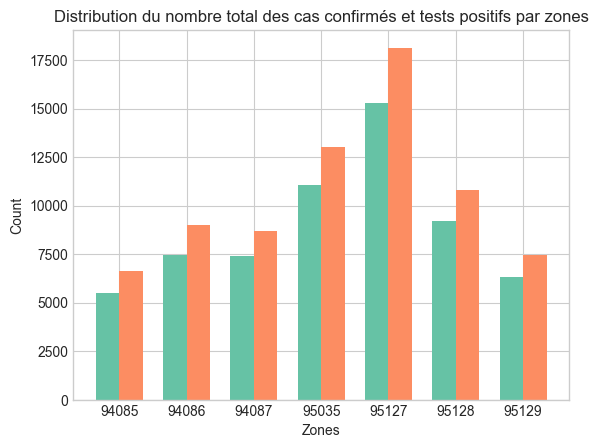

In [38]:
# Bar chart
def plot_total_cases_and_positive_tests():
    totals = df.groupby('zcta')[['case count', 'positive tests']].sum().reset_index()
    zones = totals['zcta'].tolist()
    print(totals)

    bar_width = 0.35
    index = totals.index

    plt.bar(index, totals['case count'], bar_width, label='case count')
    plt.bar(index + bar_width, totals['positive tests'], bar_width, label='positive tests')

    plt.xlabel('Zones')
    plt.ylabel('Count')
    plt.title('Distribution du nombre total des cas confirmés et tests positifs par zones')
    plt.xticks(index + bar_width / 2, zones)

    plt.show()

plot_total_cases_and_positive_tests()

# Tree map
def plot_total_cases_and_positive_tests_treemap():
    totals = df.groupby('zcta')[['case count', 'positive tests']].sum().reset_index()
    
    plot_list = []
    fig1 = px.treemap(totals, path=['zcta'], values='case count', title='Total Case Count by ZCTA')
    plot_list.append(fig1)
    fig2 = px.treemap(totals, path=['zcta'], values='positive tests', title='Total Positive Tests by ZCTA')
    plot_list.append(fig2)

    for fig in plot_list:
        fig.show()

plot_total_cases_and_positive_tests_treemap()

- Comment les tests COVID-19, les tests positifs et le nombre de cas évolue au fil du temps (hebdomadaire, mensuel et annuel) pour une zone choisit :

    test count case count positive tests Start date   end date
262     6882.0      150.0          179.0 2021-08-22 2021-09-11
266     5524.0      104.0          114.0 2021-08-01 2021-08-21


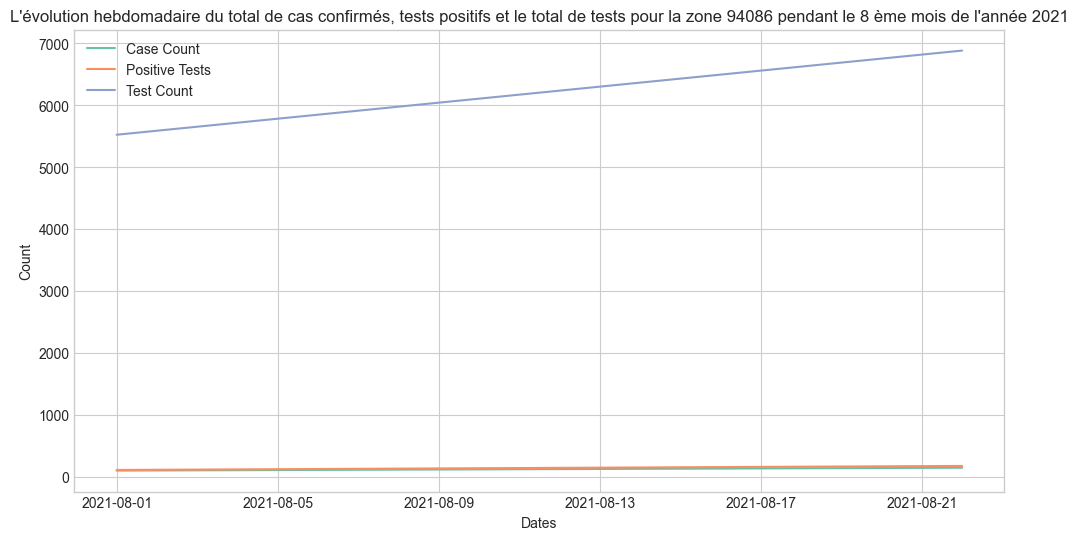

   test count   case count positive tests
0     12780.0        531.0          601.0
1      5461.0         75.0           88.0
2     11383.0        103.0          131.0
3      5270.0         55.0           68.0
4      7803.0         32.5      41.666667
5      3025.0         19.0           21.0
6      3834.0         75.0           90.0
7     12406.0        254.0          293.0
8      7362.0         48.0           66.0
9     13343.0         97.0          117.0
10     6659.0         58.0           72.0
11    18249.0  1239.328516    1465.386205


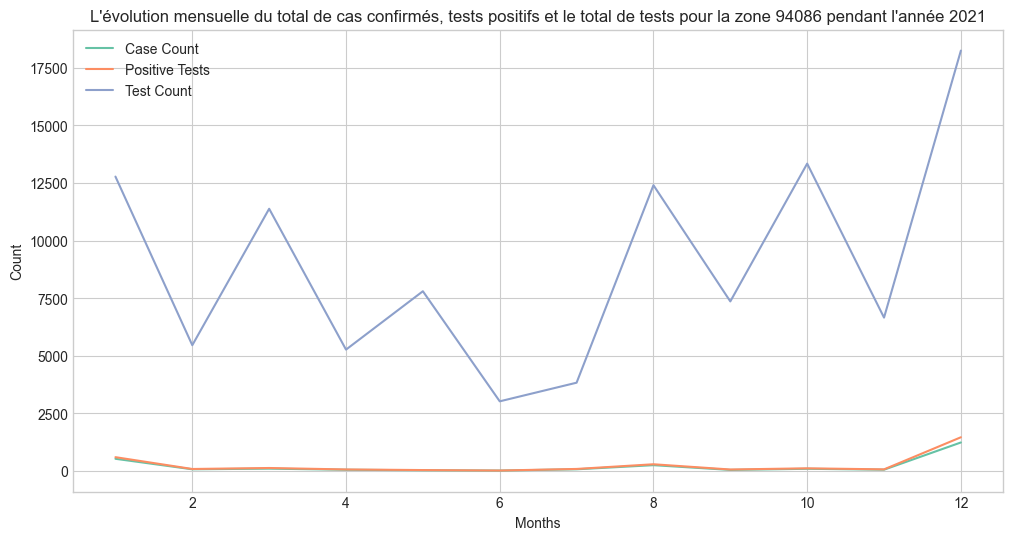

   Year   case count positive tests    test count
0  2019          0.0     224.744681   4084.262411
1  2020      1240.75    1532.489362  40875.319149
2  2021  2586.828516    3054.052872      107575.0
3  2022  3628.660601    4164.498297       58892.0


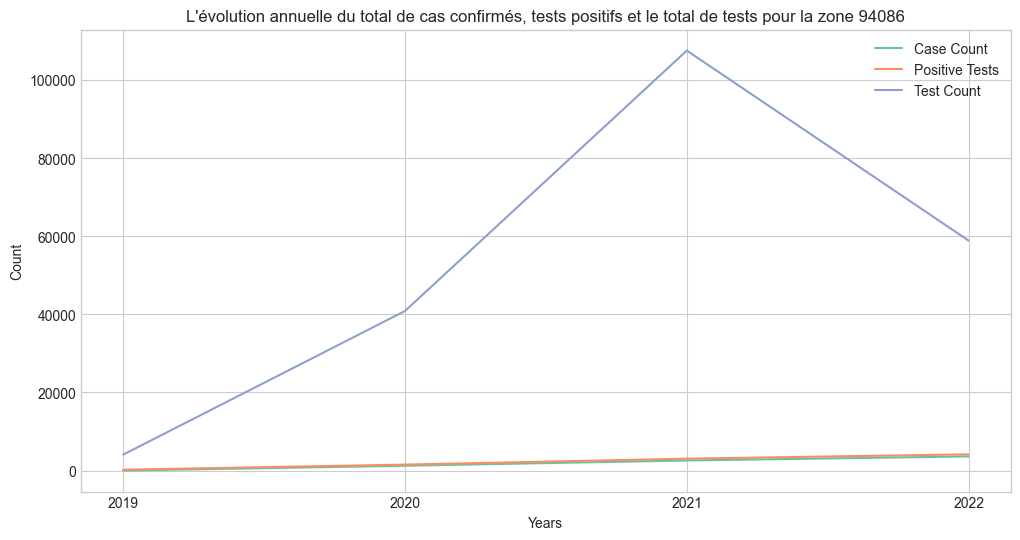

In [40]:
def visualize_data_general(chosen_zone, chosen_year, chosen_month):
    
    df['Start date'] = pd.to_datetime(df['Start date'])
    df['end date'] = pd.to_datetime(df['end date'])

    df['Month'] = df['Start date'].dt.month
    df['Year'] = df['Start date'].dt.year

    zone_df = df[df['zcta'] == chosen_zone]

    # Visualisation hebdomadaire
    plt.figure(figsize=(12, 6))
    hebdo_df = zone_df[(zone_df['Month'] == chosen_month) & (zone_df['Year'] == chosen_year)]
    print(hebdo_df[['test count', 'case count', 'positive tests', 'Start date', 'end date']])

    sns.lineplot(x='Start date', y='case count', data=hebdo_df, label='Case Count')
    sns.lineplot(x='Start date', y='positive tests', data=hebdo_df, label='Positive Tests')
    sns.lineplot(x='Start date', y='test count', data=hebdo_df, label='Test Count')
    plt.title(f'L\'évolution hebdomadaire du total de cas confirmés, tests positifs et le total de tests pour la zone {chosen_zone} pendant le {chosen_month} ème mois de l\'année {chosen_year}')
    plt.xlabel('Dates')
    plt.ylabel('Count') 
    plt.legend()
    plt.show()


    # Visualisation mensuelle
    plt.figure(figsize=(12, 6))
    monthly_df = zone_df[zone_df['Year'] == chosen_year]
    month_df = monthly_df.groupby('Month')[['case count', 'positive tests', 'test count']].sum().reset_index()
    print(month_df[['test count', 'case count', 'positive tests']])

    sns.lineplot(x='Month', y='case count', data=month_df, label='Case Count')
    sns.lineplot(x='Month', y='positive tests', data=month_df, label='Positive Tests')
    sns.lineplot(x='Month', y='test count', data=month_df, label='Test Count')    
    plt.title(f'L\'évolution mensuelle du total de cas confirmés, tests positifs et le total de tests pour la zone {chosen_zone} pendant l\'année {chosen_year}')
    plt.xlabel('Months')
    plt.ylabel('Count')
    plt.legend()
    plt.show()
    

    # Visualisation annuelle
    plt.figure(figsize=(12, 6))
    annual_df = zone_df.groupby('Year')[['case count', 'positive tests', 'test count']].sum().reset_index()
    annual_df['Year'] = annual_df['Year'].astype(int)
    print(annual_df)
    
    sns.lineplot(x='Year', y='case count', data=annual_df, label='Case Count')
    sns.lineplot(x='Year', y='positive tests', data=annual_df, label='Positive Tests')
    sns.lineplot(x='Year', y='test count', data=annual_df, label='Test Count')
    plt.title(f'L\'évolution annuelle du total de cas confirmés, tests positifs et le total de tests pour la zone {chosen_zone}')
    plt.xlabel('Years')
    plt.ylabel('Count')
    plt.xticks(annual_df['Year'])
    plt.legend()
    plt.show()

visualize_data_general(chosen_zone=94086, chosen_year=2021, chosen_month=8)

The most frequent month for the chosen zone is: 8


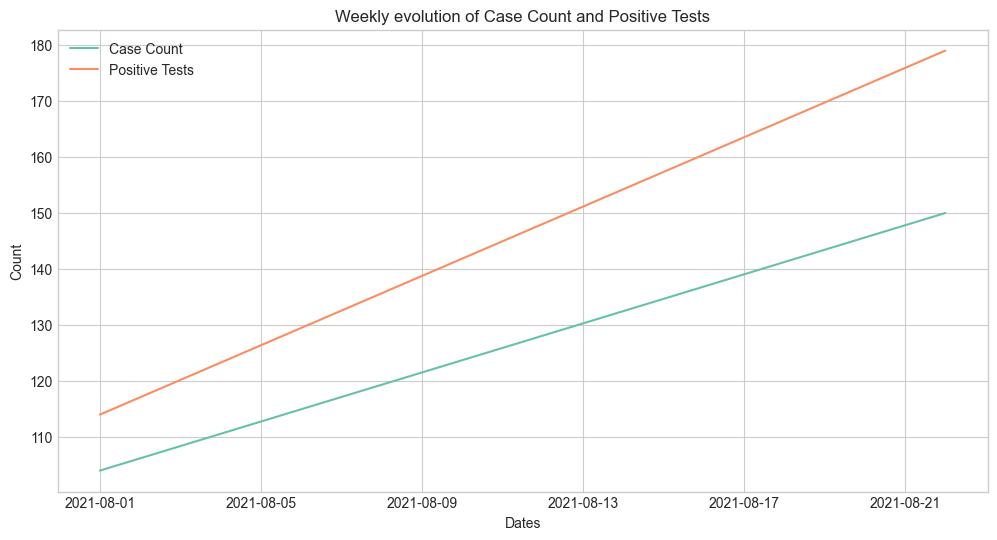

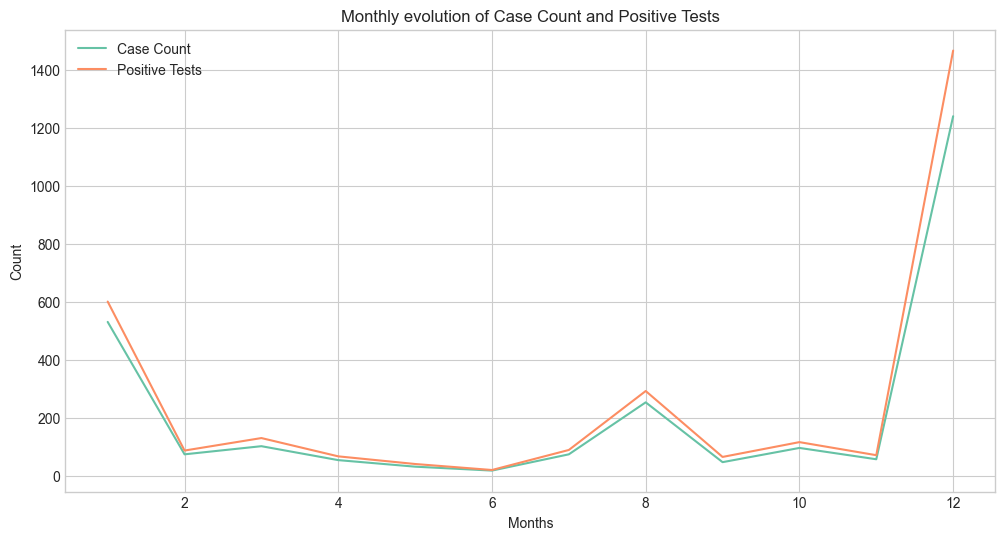

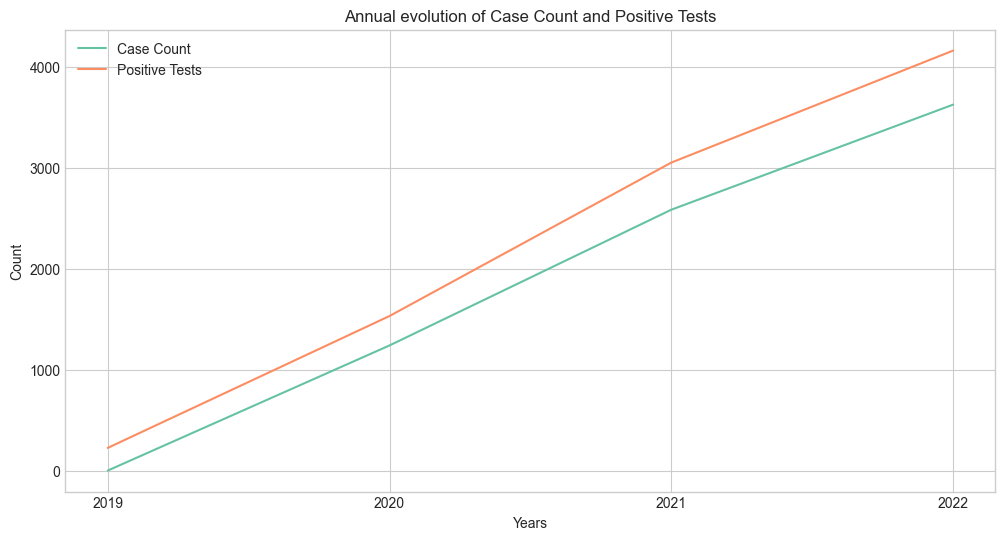

In [41]:
def visualize_data(chosen_zone, chosen_year, chosen_month):
    df['Start date'] = pd.to_datetime(df['Start date'])
    df['end date'] = pd.to_datetime(df['end date'])

    df['Month'] = df['Start date'].dt.month
    df['Year'] = df['Start date'].dt.year

    zone_df = df[df['zcta'] == chosen_zone]

    most_frequent_month = zone_df['Month'].value_counts().idxmax()
    print("The most frequent month for the chosen zone is:", most_frequent_month)

    # Visualisation hebdomadaire
    plt.figure(figsize=(12, 6))
    hebdo_df = zone_df[(zone_df['Month'] == chosen_month) & (zone_df['Year'] == chosen_year)]

    sns.lineplot(x='Start date', y='case count', data=hebdo_df, label='Case Count')
    sns.lineplot(x='Start date', y='positive tests', data=hebdo_df, label='Positive Tests')
    plt.title('Weekly evolution of Case Count and Positive Tests')
    plt.xlabel('Dates')
    plt.ylabel('Count') 
    plt.legend()
    plt.show()

    # Visualisation mensuelle
    plt.figure(figsize=(12, 6))
    monthly_df = zone_df[zone_df['Year'] == chosen_year]
    month_df = monthly_df.groupby('Month')[['case count', 'positive tests']].sum().reset_index()

    sns.lineplot(x='Month', y='case count', data=month_df, label='Case Count')
    sns.lineplot(x='Month', y='positive tests', data=month_df, label='Positive Tests')
    plt.title('Monthly evolution of Case Count and Positive Tests')
    plt.xlabel('Months')
    plt.ylabel('Count')
    plt.legend()
    plt.show()

    # Visualisation annuelle
    plt.figure(figsize=(12, 6))
    annual_df = zone_df.groupby('Year')[['case count', 'positive tests']].sum().reset_index()
    annual_df['Year'] = annual_df['Year'].astype(int)

    sns.lineplot(x='Year', y='case count', data=annual_df, label='Case Count')
    sns.lineplot(x='Year', y='positive tests', data=annual_df, label='Positive Tests')
    plt.title('Annual evolution of Case Count and Positive Tests')
    plt.xlabel('Years')
    plt.ylabel('Count')
    plt.xticks(annual_df['Year'])
    plt.legend()
    plt.show()

visualize_data(chosen_zone=94086, chosen_year=2021, chosen_month=8)


- Comment les cas covid positifs sont distribués par zone et par année ?

zcta        94085        94086        94087        95035        95127  \
Year                                                                    
2019          0.0          0.0          NaN          NaN          0.0   
2020       828.25      1240.75        884.5  1765.332974  3919.554759   
2021  2385.152554  2586.828516  2637.034892  4190.376363  6079.638409   
2022  2259.257826  3628.660601  3861.594996  5099.724043  5292.724587   

zcta        95128        95129  
Year                            
2019          0.0          NaN  
2020  1880.043883       797.25  
2021  3559.351923  2222.238623  
2022  3779.303293  3297.847592  


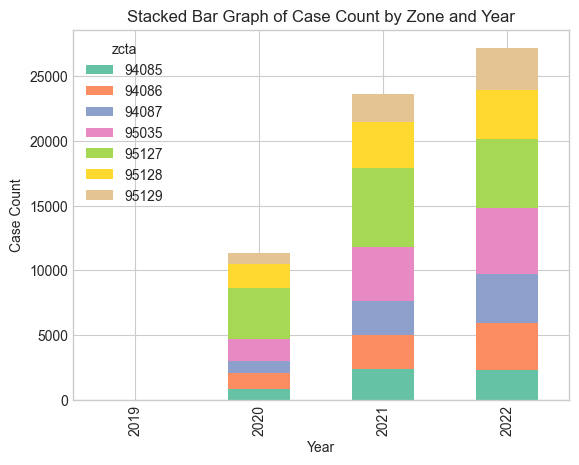

In [42]:
def plot_stacked_bar(df):
    df['Year'] = df['Start date'].dt.year
    grouped_data = df.groupby(['Year', 'zcta'])['case count'].sum().unstack()
    print(grouped_data)
    grouped_data.plot(kind='bar', stacked=True)
        
    plt.title('Stacked Bar Graph of Case Count by Zone and Year')
    plt.xlabel('Year')
    plt.ylabel('Case Count')

    plt.show()

plot_stacked_bar(df)


- Comment peut-on efficacement graphiquement représenter le rapport entre la population et le nombre de tests effectués?

   population     test count
0       23223   106554.58156
1       36975  196044.595745
2       39741  210614.061409
3       50477   211426.58156
4       56668  293192.545548
5       66256  273129.393567
6       79655  306564.900214


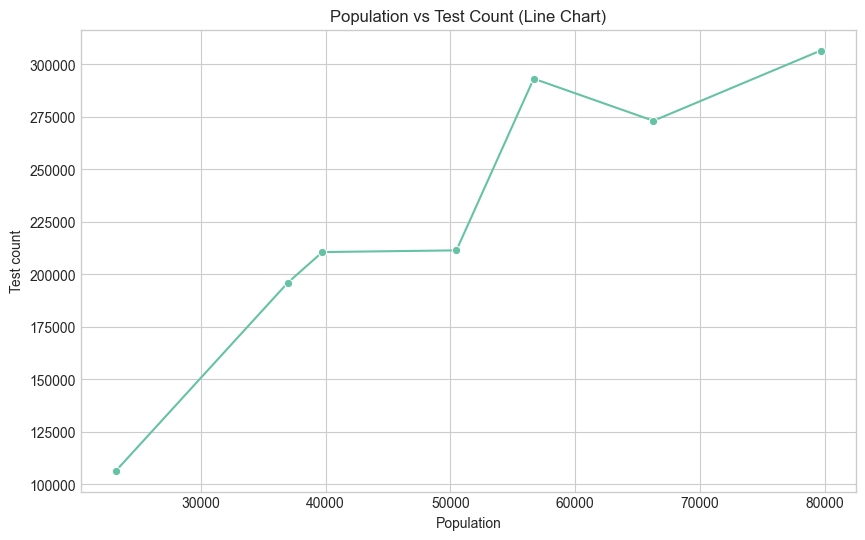

In [43]:
def plot_population_test_line():
    data = df[['population', 'test count']]
    grouped_data = data.groupby('population').sum().reset_index()
    print(grouped_data)

    plt.figure(figsize=(10, 6))
    sns.lineplot(x='population', y='test count', data=grouped_data, marker='o')
    plt.title('Population vs Test Count (Line Chart)')
    plt.xlabel('Population')
    plt.ylabel('Test count')
    plt.show()

plot_population_test_line()


- Quelles sont les 5 zones les plus fortement impactées par le coronavirus?

zcta
94085     5472.66038
95129    6317.336215
94087    7383.129888
94086    7456.239116
95128    9218.699099
Name: case count, dtype: object


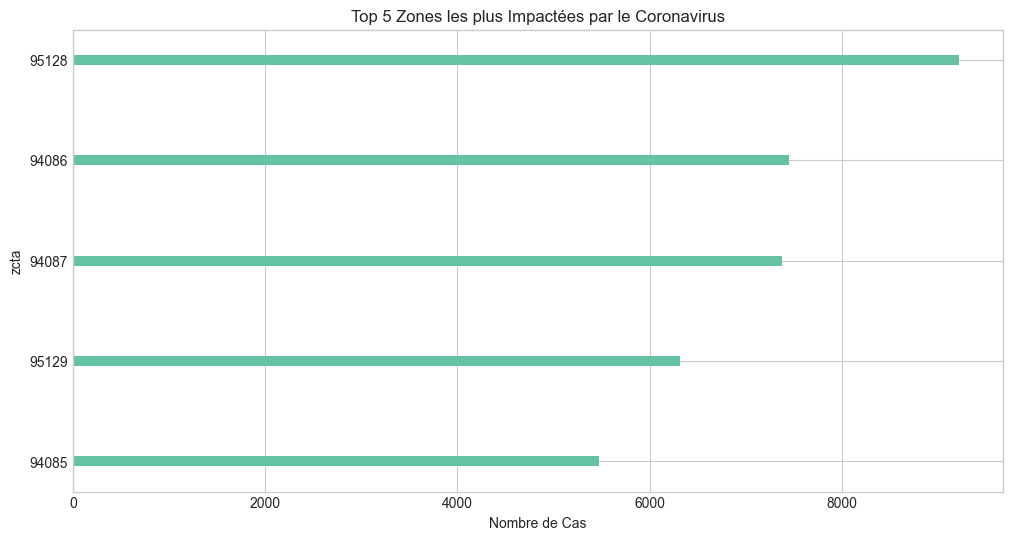

In [44]:
def plot_top_zones_impacted(n):
    grouped_data = df.groupby('zcta')['case count'].sum().sort_values(ascending=True).head(n)
    print(grouped_data)

    bar_width = 0.1

    grouped_data.plot.barh(figsize=(12, 6), width=bar_width)

    plt.title(f'Top {n} Zones les plus Impactées par le Coronavirus')
    plt.xlabel('Nombre de Cas')
    plt.show()

plot_top_zones_impacted(5)


- Quel est le rapport entre les cas confirmés, les tests effectués et les tests positifs a une periode choisie pour chaque zone ? 

    zcta positive tests test count case count
0  94085           23.0      409.0       20.0
1  94086           41.0      984.0       39.0
2  94087           48.0     1280.0       39.0
3  95035          106.0     1392.0       86.0
4  95127           49.0     1276.0       40.0
5  95128           20.0      803.0       14.0
6  95129           42.0      707.0       39.0


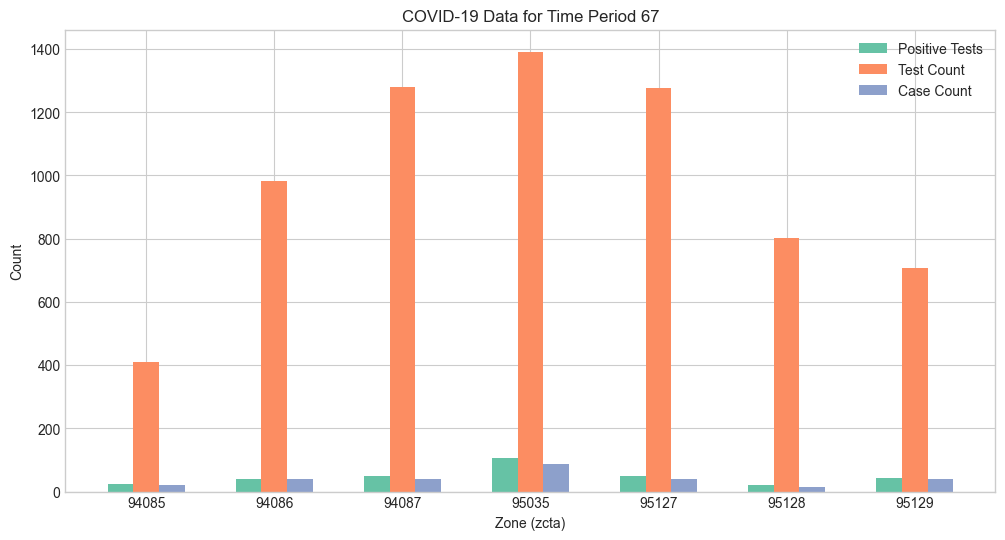

In [45]:
def plot_covid_data(time_period):
    selected_data = df[(df['time_period'] == time_period)]
    grouped_data = selected_data.groupby('zcta')[['positive tests', 'test count', 'case count']].sum().reset_index()

    fig, ax = plt.subplots(figsize=(12, 6))

    bar_width = 0.2
    index = grouped_data.index

    print(grouped_data)

    ax.bar(index - bar_width, grouped_data['positive tests'], width=bar_width, label='Positive Tests')
    ax.bar(index, grouped_data['test count'], width=bar_width, label='Test Count')
    ax.bar(index + bar_width, grouped_data['case count'], width=bar_width, label='Case Count')

    ax.set_xticks(index)
    ax.set_xticklabels(grouped_data['zcta'])
    ax.set_xlabel('Zone (zcta)')
    ax.set_ylabel('Count')
    ax.set_title(f'COVID-19 Data for Time Period {time_period}')
    ax.legend()

    plt.show()

plot_covid_data(67)  


## Part 3/3
## Extraction de motifs fréquents, règles d’associations et corrélations

Visualisation du dataset 3 :

In [46]:
csv_file_path = 'Dataset3.xlsx - 8.forFMI.csv'
dataset3 = pd.read_csv(csv_file_path, delimiter=',', decimal=',')
dataset3=dataset3.to_numpy()
pd.DataFrame(dataset3).head()


,0,1,2,3,4,5
0,24.87,82.84,295.61,Clayey,rice,DAP
1,28.69,96.65,178.96,laterite,Coconut,Good NPK
2,20.27,81.64,270.44,silty clay,rice,MOP
3,25.07,95.02,192.9,sandy,Coconut,Urea
4,25.04,95.9,174.8,coastal,Coconut,Urea


Discrétiser ces données continues de cet attribut, en utilisant ces 2 méthodes :

In [47]:

def Discretisation(methode,attribut):
    global dataset3
    vals=dataset3[:,attribut].copy()
    vals.sort()

    if methode:
        q = int(input("Entrez nbr de partie "))
        nbrelmt=math.ceil(dataset3[:,attribut].shape[0]/q)
        
        for  val in range(0,dataset3[:,attribut].shape[0]):  
            for i in range(0,vals.shape[0],nbrelmt):
                if(vals[i]>dataset3[val,attribut]):
                    sup=i
                    break
            dataset3[val,attribut]=np.mean(vals[sup-nbrelmt:sup])       
    else:

        #discretisation
        K=1+(10/3)*np.log10(dataset3.shape[0])
    
        largeur= (dataset3[:,attribut].max() - dataset3[:,attribut].min())/math.ceil(K)
        
        dic={}
        bornesup= dataset3[:,attribut].min()+largeur
        for val in vals:
            if val>=bornesup and bornesup<dataset3[:,attribut].max():
                bornesup+=largeur

            if bornesup in dic:   
                dic[bornesup].append(val)
            else:
                dic[bornesup]=[val]

        #remplacement 
        for i in range(0,dataset3[:,attribut].shape[0]):
            for item in dic.items():
                 if (dataset3[i,attribut]>=item[0]-largeur and dataset3[i,attribut]<item[0]):
                     dataset3[i,attribut]=np.mean(item[1])
                     break     

10


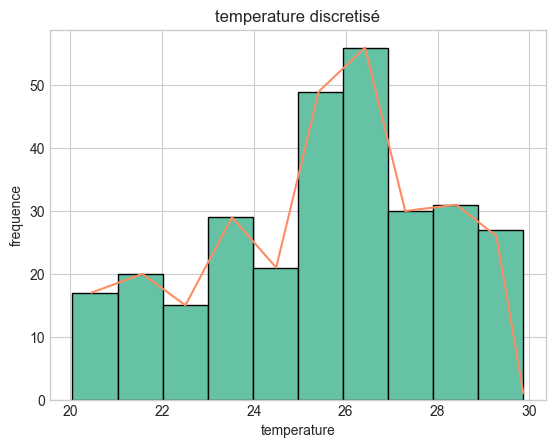

In [48]:

#avant dicretisation manuelle
nbrbins=math.ceil(1+(10/3)*np.log10(dataset3.shape[0]))
print(nbrbins)
attribut=0
plt.hist(dataset3[:,attribut],bins=nbrbins,edgecolor='black')
#discretiser
Discretisation(0,attribut)

#apres discretisation
freq=Counter(dataset3[:,0])
x_values = np.sort(list(freq.keys()))
y_values = [freq[x] for x in x_values]
plt.plot(x_values, y_values)
plt.xlabel('temperature')
plt.ylabel('frequence')
plt.title('temperature discretisé')
plt.show()


Extraction des motifs fréquents puis les règles d’association en utilisant l’algorithme Apriori et effectuer des expérimentations en variant les valeurs de Min_Supp et Min_Conf:

In [49]:
def Ck_generator(k,L,datasetT):
    if k==1:
        uniItemListe=set()
        for i in range(0,len(datasetT)):
            uniItemListe.update(set(datasetT[i] ))
        return [(v,) for v in uniItemListe]
    else:
        C=[]
        if len(L)==0: return C
        listeitemsunique=sorted(set([element for tuple in L.keys() for element in tuple]))
        if len(listeitemsunique)<k: return []
        combinations_list = list(combinations(listeitemsunique, k))
        if k==2: 
            return combinations_list
        #le pruning
        for combi in combinations_list:
            exist=True
            sous_combinations_list = list(combinations(combi, k-1))
            
            for sous_combi in sous_combinations_list:
                if sous_combi not in list(L.keys()):
                    exist=False
                    break
            if exist==True:
                C.append(combi)   
        return C
def support_calculator(C,datasetT):
    dico={}
    dico.update({val:0 for val in C})
    for row in datasetT:
        combinations_list = list(combinations(row, len(list(dico.keys())[0])))
        for val in combinations_list:
            if val in dico: 
                dico[val]+=1
    dico.update({key:val/len(datasetT) for key,val in dico.items()})
  
    return dico

def Lk_generator(C,supp_min):
    c={}
    c=({key:float(val) for key,val in C.items() if float(val)>=supp_min})
    return c

In [50]:
#form transaction table
dataset3 = [np.sort(list(four)) for four in zip(dataset3[:,0].astype(str),dataset3[:,3],dataset3[:,4],dataset3[:,5])]
pd.DataFrame(dataset3).head()

,0,1,2,3
0,24.486666666666668,Clayey,DAP,rice
1,28.410322580645165,Coconut,Good NPK,laterite
2,20.460588235294114,MOP,rice,silty clay
3,25.41224489795918,Coconut,Urea,sandy
4,25.41224489795918,Coconut,Urea,coastal


In [51]:
def appriori(min_supp,datasetT):
    L=[]
    k=1
    C=Ck_generator(k,None,datasetT)
 
    while(len(C)!=0):
        S=support_calculator(C,datasetT)
     
        l=Lk_generator(S,min_supp)
        if len(l)!=0:L.append(l)
       
        k+=1
        C=Ck_generator(k,l,None)
        
    return L


Extraction des fortes règles d’associations :

In [52]:
def regle_association(L):
    regles=pd.DataFrame()
    first=True
    for key,value in L.items():
        if first==True:
            k=len(key)
            first==False
        if k==2 :
                new_row = {'antecedant':(key[0],),'consequent':(key[1],),'mesure':0.0,'support':value}
                regles = pd.concat([regles, pd.DataFrame([new_row])], ignore_index=True)
                new_row={'antecedant':(key[1],),'consequent':(key[0],),'mesure':0.0,'support':value}
                regles = pd.concat([regles, pd.DataFrame([new_row])], ignore_index=True)
        else:
            for i in range(k-1,k-(k//2)-1,-1):#4-3 6-4 /2 +1   7-4 5-3 +1 /2
                sous_combinations_list = list(combinations(key,i))#ab c  / ac bc 
                for sous_comb in sous_combinations_list:
                    reste=sorted(set(key).symmetric_difference(sous_comb))
                    regles = pd.concat([regles, pd.DataFrame([{'antecedant':tuple(reste),'consequent':sous_comb,'mesure':0.0,'support':value}])], ignore_index=True)
                    if not len(tuple(reste))==len(sous_comb):
                        regles = pd.concat([regles, pd.DataFrame([{'antecedant':sous_comb,'consequent':tuple(reste),'mesure':0.0,'support':value}])], ignore_index=True)
        
    return regles

In [53]:
def mesure_calculator(r,methode,L):#A,D->B,C
    if methode==0:#confidence
        return (r["support"]/L[len(r["antecedant"])-1][r["antecedant"]])
    elif methode==1:#cosine
        return (r["support"]/math.sqrt(L[len(r["antecedant"])-1][r["antecedant"]]*L[len(r["consequent"])-1][r["consequent"]]))
    elif methode==2:#lift
        return r["support"]/(L[len(r["antecedant"])-1][r["antecedant"]]*L[len(r["consequent"])-1][r["consequent"]])
    elif methode==3:#jackard
        return r["support"]/(L[len(r["antecedant"])-1][r["antecedant"]]+L[len(r["consequent"])-1][r["consequent"]]- r["support"])
    else:#kulc
        return 0.5*((r["support"]/L[len(r["antecedant"])-1][r["antecedant"]])+(r["support"]/L[len(r["consequent"])-1][r["consequent"]]))

In [54]:
def regles_frequente(L, conf_min,m):

    regles=pd.DataFrame()
    for l in L[1:]:
        a=len(regles)
        regles= pd.concat([regles, regle_association(l)], ignore_index=True)
        

    for i in range(0,len(regles)):
        regles.iloc[i,2]=mesure_calculator(regles.loc[i],m,L)
    
    if not len(regles)==0:
        regles=regles[regles['mesure'] >= conf_min]
        
    return regles

In [71]:
L=appriori(0.01,dataset3)
print(L)
r=regles_frequente(L,0.1,0)
r

[{('clay loam',): 0.08135593220338982, ('Clayey',): 0.18305084745762712, ('Coconut',): 0.5152542372881356, ('coastal',): 0.1694915254237288, ('26.421249999999997',): 0.18983050847457628, ('alluvial',): 0.08813559322033898, ('sandy',): 0.16271186440677965, ('28.410322580645165',): 0.10508474576271186, ('29.283076923076926',): 0.08813559322033898, ('MOP',): 0.2542372881355932, ('20.460588235294114',): 0.0576271186440678, ('24.486666666666668',): 0.0711864406779661, ('21.5725',): 0.06779661016949153, ('Good NPK',): 0.11186440677966102, ('laterite',): 0.09491525423728814, ('DAP',): 0.29152542372881357, ('23.524482758620696',): 0.09830508474576272, ('Urea',): 0.3423728813559322, ('27.297000000000004',): 0.1016949152542373, ('22.509999999999998',): 0.05084745762711865, ('rice',): 0.4847457627118644, ('25.41224489795918',): 0.16610169491525423, ('silty clay',): 0.22033898305084745}, {('20.460588235294114', 'Clayey'): 0.023728813559322035, ('20.460588235294114', 'MOP'): 0.023728813559322035, (

,antecedant,consequent,mesure,support
0,"(20.460588235294114,)","(Clayey,)",0.411765,0.023729
1,"(Clayey,)","(20.460588235294114,)",0.129630,0.023729
2,"(20.460588235294114,)","(MOP,)",0.411765,0.023729
4,"(20.460588235294114,)","(Urea,)",0.411765,0.023729
6,"(20.460588235294114,)","(rice,)",0.882353,0.050847
...,...,...,...,...
1739,"(Coconut, Urea, coastal)","(29.283076923076926,)",0.210526,0.013559
1740,"(Urea, coastal)","(29.283076923076926, Coconut)",0.210526,0.013559
1743,"(29.283076923076926, coastal)","(Coconut, Urea)",0.444444,0.013559
1744,"(29.283076923076926, Urea)","(Coconut, coastal)",0.500000,0.013559


In [56]:
te = TransactionEncoder()
te_ary = te.fit(dataset3).transform(dataset3)
df = pd.DataFrame(te_ary, columns=te.columns_)

frequent_itemsets = apriori(df, min_support=0.01, use_colnames=True)
print(frequent_itemsets)

rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.1)
print(rules)


      support                                        itemsets
0    0.057627                            (20.460588235294114)
1    0.067797                                       (21.5725)
2    0.050847                            (22.509999999999998)
3    0.098305                            (23.524482758620696)
4    0.071186                            (24.486666666666668)
..        ...                                             ...
331  0.010169      (Urea, Coconut, sandy, 28.410322580645165)
332  0.010169     (DAP, coastal, Coconut, 29.283076923076926)
333  0.010169  (Good NPK, Coconut, sandy, 29.283076923076926)
334  0.010169    (MOP, Coconut, alluvial, 29.283076923076926)
335  0.013559    (Urea, coastal, Coconut, 29.283076923076926)

[336 rows x 2 columns]
                        antecedents                    consequents  \
0                          (Clayey)           (20.460588235294114)   
1              (20.460588235294114)                       (Clayey)   
2              (20.460

### experimentation

In [57]:
#experimentation
results= np.empty((0,3),float)
for sup_min in np.arange(0.01,0.2,0.01):
    for conf_min in np.arange(0.01,0.2,0.01):
        L=appriori(sup_min,dataset3)
        rs=regles_frequente(L,conf_min,0)
    
        results=np.vstack((results,np.array([sup_min,conf_min,len(rs)])))
np.set_printoptions(suppress=True)
print(results)
# with open("nbrRegles.csv", 'w', newline='') as csv_file:
#     csv_writer = csv.writer(csv_file)
#     for i in range(0,len(results)):
#         csv_writer.writerow(results[i,:])

[[   0.01    0.01 1746.  ]
 [   0.01    0.02 1729.  ]
 [   0.01    0.03 1679.  ]
 ...
 [   0.19    0.17    2.  ]
 [   0.19    0.18    2.  ]
 [   0.19    0.19    2.  ]]


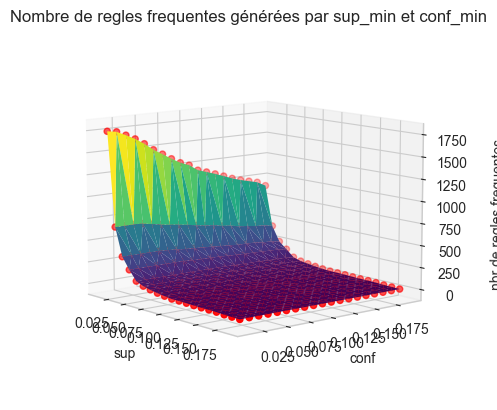

In [58]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial import Delaunay

fig, ax = plt.subplots(subplot_kw={'projection': '3d'})

Z = results[:, 2].reshape(results.shape[0], 1)
ax.scatter(results[:, 0], results[:, 1], Z, c='r', marker='o')

tri = Delaunay(results[:, :2])

ax.plot_trisurf(results[:, 0], results[:, 1], Z.flatten(), triangles=tri.simplices, cmap="viridis", linewidth=0.9, antialiased=True)

ax.set_xlabel('sup')
ax.set_ylabel('conf')
ax.set_zlabel('nbr de regles frequentes', labelpad=10)

ax.view_init(elev=10, azim=-40)
plt.title("Nombre de regles frequentes générées par sup_min et conf_min")
plt.show()


In [59]:
resultsf= np.empty((0,2),float)
for sup_min in np.arange(0.2,0.0,-0.001):
    L=appriori(sup_min,dataset3)
    resultsf=np.vstack((resultsf,np.array([sup_min,sum(len(l) for l in L)]))) 

# with open("nbrmotifs.csv", 'w', newline='') as csv_file:
#     csv_writer = csv.writer(csv_file)
#     for i in range(0,len(resultsf)):
#         csv_writer.writerow(resultsf[i,:])

In [60]:

TimeResults= np.empty((0,2),float)

for sup_min in np.arange(0.3,0.0,-0.002):
    duree=0.0
    for j in range(0,10):
        start=time.time()
        L=appriori(sup_min,dataset3)
        duree+=time.time()-start
    TimeResults=np.vstack((TimeResults,np.array([sup_min,duree/10.0])))
    
# with open("temps.csv", 'w', newline='') as csv_file:
#     csv_writer = csv.writer(csv_file)
#     for i in range(0,len(TimeResults)):
#         csv_writer.writerow(TimeResults[i,:])


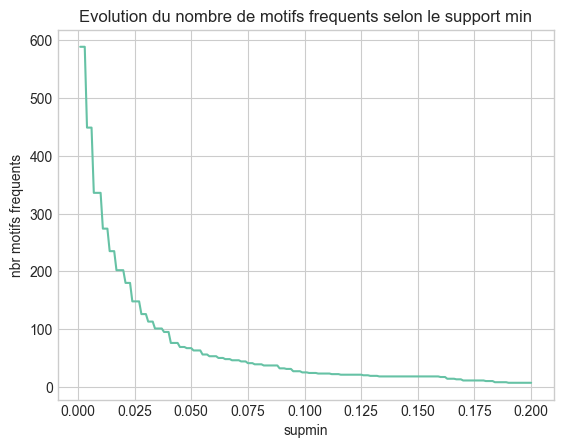

In [61]:

x = resultsf[:,0]
y = resultsf[:,1]

plt.plot(x, y)
plt.title('Evolution du nombre de motifs frequents selon le support min')
plt.xlabel('supmin')
plt.ylabel('nbr motifs frequents')

plt.show()

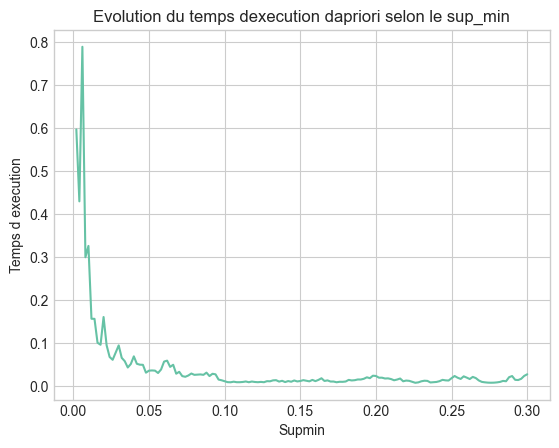

In [62]:

x = TimeResults[:,0]
y = TimeResults[:,1]

plt.plot(x, y)
plt.title('Evolution du temps d''execution d''apriori selon le sup_min')
plt.xlabel('Supmin')
plt.ylabel('Temps d execution')

plt.show()

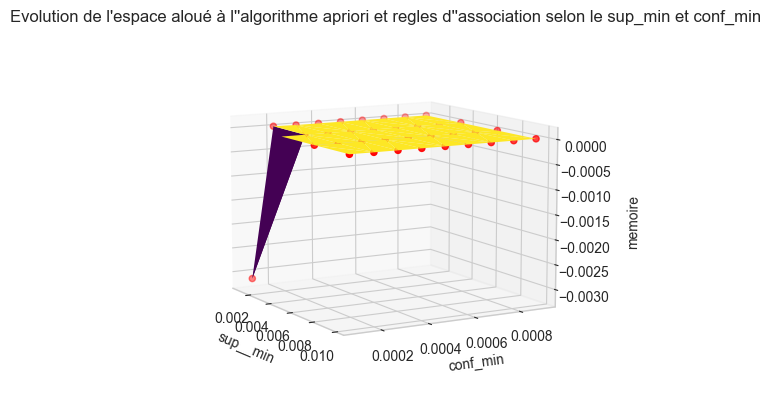

In [63]:
import psutil
resultsMemory= np.empty((0,3),float)
for sup_min in np.arange(0.001,0.01,0.003):
    for conf_min in np.arange(0.0001,0.001,0.0001):
        initial_memory = psutil.Process().memory_info().rss / 1024 / 1024 /2024 # in MB
        L=appriori(sup_min,dataset3)
        rs=regles_frequente(L,conf_min,0)
        final_memory = psutil.Process().memory_info().rss / 1024 / 1024 /2024 # in MB
        resultsMemory=np.vstack((resultsMemory,np.array([sup_min,conf_min,final_memory-initial_memory])))

fig, ax = plt.subplots(subplot_kw={'projection': '3d'})

Z = resultsMemory[:, 2].reshape(resultsMemory.shape[0], 1)
ax.scatter(resultsMemory[:, 0], resultsMemory[:, 1], Z, c='r', marker='o')

# Create Delaunay triangulation
tri = Delaunay(resultsMemory[:, :2])

# Plot the surface using the triangulation
ax.plot_trisurf(resultsMemory[:, 0], resultsMemory[:, 1], Z.flatten(), triangles=tri.simplices, cmap="viridis", linewidth=0.9, antialiased=True)

ax.set_xlabel('sup__min')
ax.set_ylabel('conf_min')
ax.set_zlabel('memoire',labelpad=10)
ax.view_init(elev=10, azim=-30)
plt.title("Evolution de l'espace aloué à l''algorithme apriori et regles d''association selon le sup_min et conf_min")
plt.show()


Recommendation :

In [73]:
L=appriori(0.01,dataset3)
r=regles_frequente(L,0.2,0)

def recommendation(instance, method):#instance is a list
    r_filtered=[]
    for index, row in r.iterrows():
        if method == "Strict":
            if row[0]==tuple(sorted(instance)):
                r_filtered.append(row)
        else:
            if set(list(row[0])).issubset(set(instance)):
                r_filtered.append(row)

    print(pd.DataFrame([r["consequent"] for r in r_filtered]))

recommendation(["Urea","29.283076923076926","Coconut"], "Strict")

C:\Users\Asus Zenbook Flip\AppData\Local\Temp\ipykernel_13968\1750868667.py:8: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



         0
0  coastal
